In [1]:
# @misc{fayek2016,
#   title   = "Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between",
#   author  = "Haytham M. Fayek",
#   year    = "2016",
#   url     = "https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html"
# }

Setup

In [2]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('./audio/OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

Parameters

In [3]:
pre_emphasis = 0.97
frame_size = 0.025
frame_stride = 0.01
NFFT = 512
nfilt = 40
num_ceps = 12
cep_lifter = 22

Pre-Emphasis

In [4]:
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

Framing

In [5]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

Window

In [6]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

Fourier-Transform and Power Spectrum

In [7]:
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

Filter Banks

In [8]:
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

Mel-frequency Cepstral Coefficients (MFCCs)

In [9]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [10]:
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*

Mean Normalization

In [11]:
# filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

In [12]:
# mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)


---
# Gráficos


In [13]:
import matplotlib.pyplot as plt
import scipy.signal

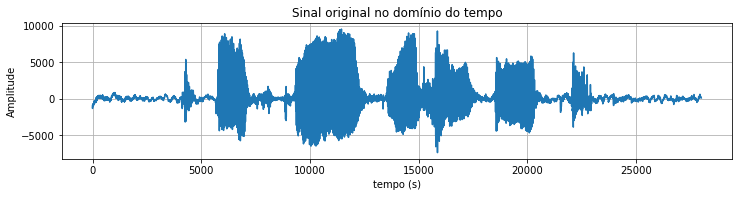

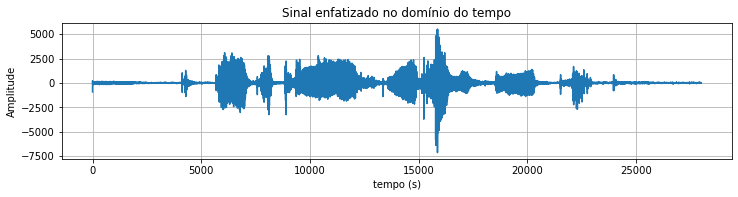

In [14]:
plt.figure(figsize=(12,2.5));
plt.plot(signal);

plt.title('Sinal original no domínio do tempo')
plt.xlabel('tempo (s)'); plt.ylabel('Amplitude');
plt.grid(which='both')

plt.figure(figsize=(12,2.5));
plt.plot(emphasized_signal);

plt.title('Sinal enfatizado no domínio do tempo')
plt.xlabel('tempo (s)'); plt.ylabel('Amplitude');
plt.grid(which='both')

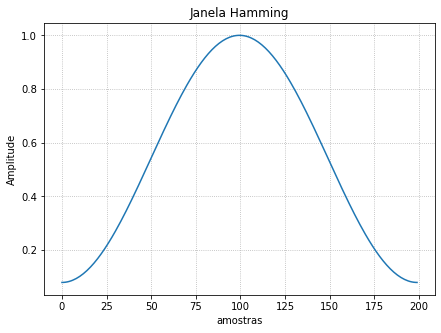

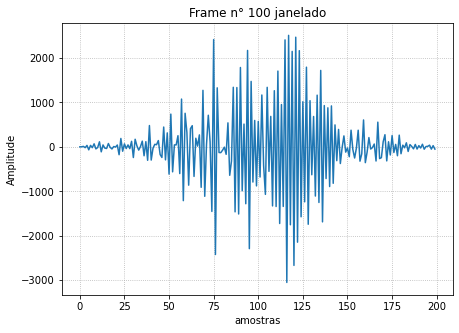

In [15]:
plt.figure(figsize=(7,5));
plt.plot(numpy.hamming(frame_length));
plt.title('Janela Hamming')
plt.xlabel('amostras'); plt.ylabel('Amplitude');
plt.grid(which='both', linestyle='dotted')

nFrame=100
plt.figure(figsize=(7,5));
plt.plot(frames[nFrame]);
plt.title(f'Frame n° {nFrame} janelado')
plt.xlabel('amostras'); plt.ylabel('Amplitude');
plt.grid(which='both', linestyle='dotted')

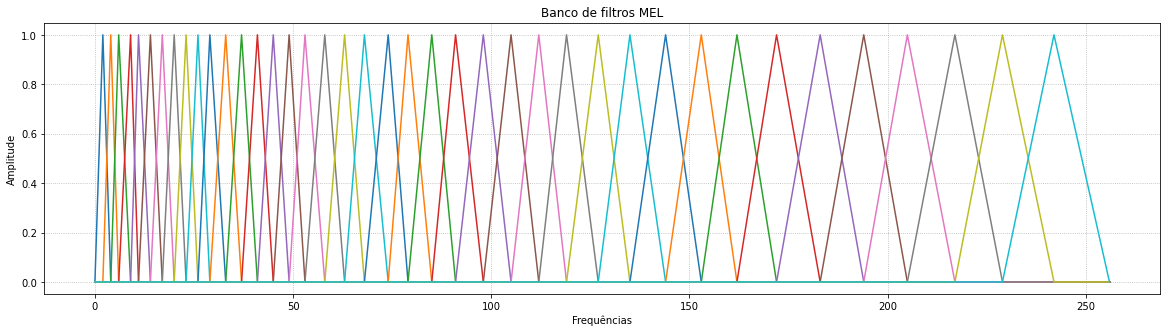

In [16]:
# plt.plot(hz_points);

plt.figure(figsize=(20,5));
for i in range(nfilt):
    plt.plot(fbank[i]);
plt.title('Banco de filtros MEL')
plt.xlabel('Frequências'); plt.ylabel('Amplitude');
plt.grid(which='both', linestyle='dotted')

In [17]:
print(filter_banks.shape)
# plt.plot(filter_banks)

(348, 40)


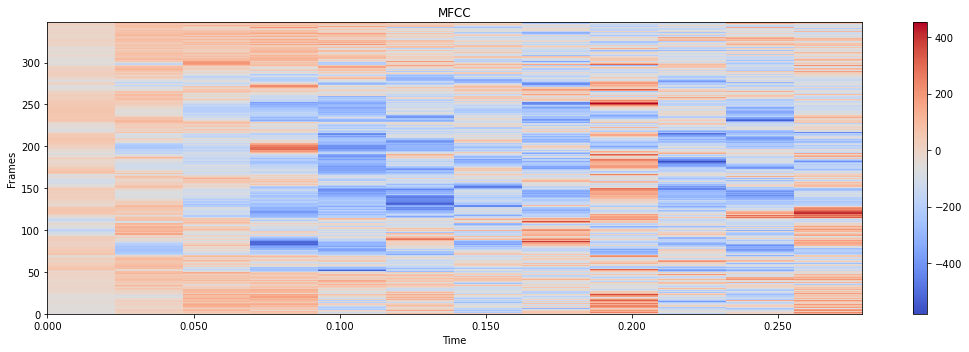

(348, 12)
[[ -47.56789461    9.49977234   19.33609685 ... -162.50558754
     4.49872983  129.17775681]
 [ -36.43134752   -3.56248835   73.40163695 ... -211.17528234
  -205.83237932  167.4228818 ]
 [ -59.65984612   15.12060036   67.18448276 ...  -71.14042827
    -4.28524554  241.24363063]
 ...
 [   8.4146385    48.31096582   34.31484928 ...  -97.44844087
   -57.6225855  -203.1607774 ]
 [  16.47984673   58.57224423   42.59394182 ...  -94.22412689
   -49.72948276  -79.83489886]
 [   4.44331939   88.74847636   76.60722124 ... -124.56625781
   135.82064445   71.29245139]]


In [18]:
import librosa.display
def plotMFCC(mfcc):
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='frames')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# N1, N2 = mfcc.shape
# list1 = []
# list2 = []
# for i in range(N1-1):
#     for j in range(N2-1):
#         list1.append(mfcc[i][j])
#     list2.append(list1)

plotMFCC(mfcc)
print(mfcc.shape)
print(mfcc)

In [19]:
# import ctypes  # An included library with Python install.
# def Mbox(title, text, style):
#     return ctypes.windll.user32.MessageBoxW(0, text, title, style)

# Mbox('Banco de Filtros MEL', 'Filtros utilizados parar descatacar as variações nas baixas frequências.\n\nO ouvido humano tem uma percepção muito mais apurada das baixas frequências', 0)